# 파이썬으로 직방 데이터 크롤링하기
* 난이도 : ★★★★★☆☆☆☆☆
* 필요라이브러리: requests, BeautifulSoup4, json
* https://www.zigbang.com/ 직방 주소

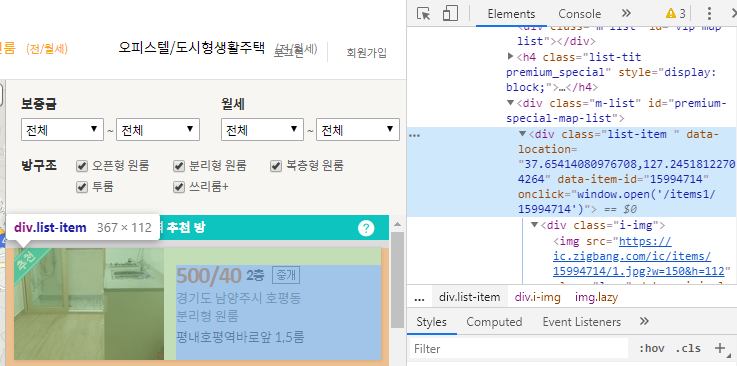

In [ ]:
# 필요 라이브러리 임포트
import requests
from bs4 import BeautifulSoup

url = "https://www.zigbang.com/search/map?lat=37.6359825134277&lng=127.216468811035&zoom=5"
r = requests.get(url)
bs = BeautifulSoup(r.text, "lxml")
divs = bs.select("div.list-item")
print(divs)

## 직방데이터가 셀렉터에 의해 나오지 않는 이유

* 직방 페이지의 결과는 직접 화면에 출력하는 방식이 아니라 내부에서 자바스크립트를 통해 API를 호출해서 API 의 결과를 출력하는 방식으로 HTML 문자열 데이터안에는 우리가 원하는 데이터가 존재하지 않습니다.
* 따라서 직방 데이터를 파싱하기 위해서는 직방 웹사이트가 어떻게 구동되는지를 이해해야할 필요가 있습니다.

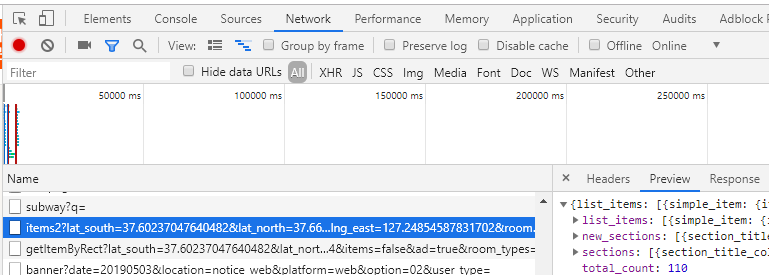

* 개발자도구의 네트워크를 분석해보면 실제 데이터는 api 를 호출해서 얻는다는걸 알 수 있습니다.

In [ ]:
# 필요 라이브러리 임포트
import requests
# api 를 직접 호출해서 결과를 얻을때 결과는 json 형태로 리턴되기 때문에 json을 사용
import json

keyword = "서울시 광진구"

# 직방의 동작 방식은 검색어가 입력되면 해당 검색어의 GPS 좌표를 구해서
# GPS 좌표값을 기준으로 동작하게끔 되어있다.
url = "https://apis.zigbang.com/search/all?q={}&type=officetel".format(keyword)
r = requests.get(url)
result = json.loads(r.text)
if result["success"]:
    lat = result["items"][0]["lat"] # 위도
    lng = result["items"][0]["lng"] # 경도

# 검색된 위치의 GPS 좌표를 중심점으로 사각형을 생성한다.
# 그리고 최종 결과는 그 사각형 내의 모든 데이터를 수집하는 방식이다.
# 실제 직방에서 해당 사격형은 자바스크립트 함수에 의해 계산된다.
# https://www.zigbang.com/Content/js/map.js 해당 파일안에 getMapClustersAsync함수에 의해 계산되는데
# 해당 함수에서 사용하는 내용은 다음 지도 API 를 사용하는 걸로 보임
# 그러나 현재 방식으로는 자바스크립을 실행시키려면 javascript을 실행가능하게 렌더링을 해야하는데
# 그러면 실행속도가 떨어지므로 일단 직접 적정한 수치를 계산하여 사용(오차가 생길수 있음)
south = lat - 0.03370855171711
north = lat + 0.0335695291371
west = float(lng) - 0.0319765406923
east = float(lng) + 0.0320013566581

# 직방 페이지가 사용하는 API 를 직접 접속
# https://apis.zigbang.com/v3/items2?lat_south=37.50490762870279&lat_north=37.572185709557&lng_west=127.05039603206171&lng_east=127.11437592941215&room=[01,02,03,04,05]
url = "https://apis.zigbang.com/v3/items2?lat_south={}&lat_north={}&lng_west={}&lng_east={}&room=[01,02,03,04,05]".format(south, north, west, east)
r = requests.get(url)

item_ids = []
datas = json.loads(r.text)
for item in datas["list_items"]:
    item_ids.append(item["simple_item"]["item_id"])

url = "https://apis.zigbang.com/v3/items?detail=true&item_ids={}".format(item_ids[0:60])
r = requests.get(url)
results = json.loads(r.text)
for i in results["items"]:
    title = i["title"]
    item = i["item"]
    s_title = item["title"]
    building_type = item["building_type"]
    view_count = item["view_count"]
    updated_at = item["updated_at"]
    size_m2 = item["size_m2"]
    size = item["size"]
    address = item["address1"]
    options = item["options"]
    rent = item["rent"]
    deposit = item["deposit"]
    
    print((address, deposit, rent, building_type, size, view_count, options))


In [ ]:
# 함수화 시켜서 더 스마트하게 작업
import requests
import json

def get_bang(keyword):
    url = "https://apis.zigbang.com/search/all?q={}&type=officetel".format(keyword)
    r = requests.get(url)
    result = json.loads(r.text)
    if result["success"]:
        lat = result["items"][0]["lat"]
        lng = result["items"][0]["lng"]

        
    south = lat - 0.03370855171711
    north = lat + 0.0335695291371
    west = float(lng) - 0.0319765406923
    east = float(lng) + 0.0320013566581

    # 직방 페이지가 사용하는 API 를 직접 접속
    # https://apis.zigbang.com/v3/items2?lat_south=37.50490762870279&lat_north=37.572185709557&lng_west=127.05039603206171&lng_east=127.11437592941215&room=[01,02,03,04,05]
    url = "https://apis.zigbang.com/v3/items2?lat_south={}&lat_north={}&lng_west={}&lng_east={}&room=[01,02,03,04,05]".format(south, north, west, east)
    r = requests.get(url)

    bang_lists = []
    item_ids = []
    datas = json.loads(r.text)
    for item in datas["list_items"]:
        item_ids.append(item["simple_item"]["item_id"])

    url = "https://apis.zigbang.com/v3/items?detail=true&item_ids={}".format(item_ids[0:60])
    r = requests.get(url)
    results = json.loads(r.text)
    for i in results["items"]:
        title = i["title"]
        item = i["item"]
        s_title = item["title"]
        building_type = item["building_type"]
        view_count = item["view_count"]
        updated_at = item["updated_at"]
        size_m2 = item["size_m2"]
        size = item["size"]
        address = item["address1"]
        options = item["options"]
        rent = item["rent"]
        deposit = item["deposit"]

        bang_lists.append((address, deposit, rent, building_type, size, view_count, options))

    return bang_lists
        
for i in get_bang("남양주 호평동"):
    print(i)